The researchers behind this dataset have built and run an image segmentation algorithm to pick out just the leaf from the background, other objects in the scene, and its stem. This will allow any classifier models to simply observe leaf shape, as intra-species variation on other features like color are too great to be reliable. 

Let's load the segmented dataset and display a sample of 25 leaves and their species name:

Found 23147 files belonging to 185 classes.


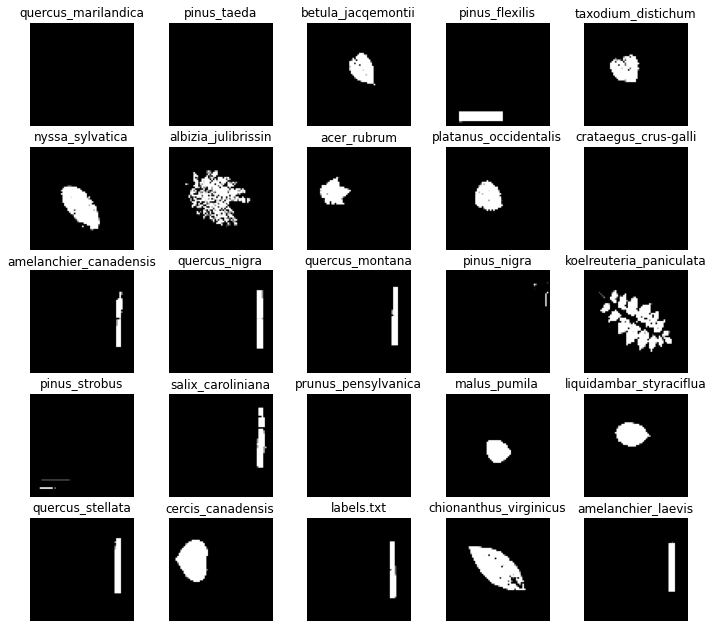

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

#some hyperparameters:
imageSize = (64, 64)
imageSizeFlat = imageSize[0]*imageSize[1]
batchSize = 25

#load full leaf dataset
leafDir = "/content/drive/Othercomputers/My Computer/RPI/21Fall/ProjectsMLAI/Projects-in-ML-and-AI/HW5/dataset/segmented/lab"
lData = tf.keras.preprocessing.image_dataset_from_directory(leafDir, labels='inferred', color_mode='grayscale', image_size=imageSize, batch_size=batchSize, shuffle=True)
#note: I'll be using the prefix "l" to indicate a variable is associated with the full [segmented] leaf dataset

#create a list of species labels
#the index of each label here corresponds to the integer-value label keras inferred
labelText = open("/content/drive/Othercomputers/My Computer/RPI/21Fall/ProjectsMLAI/Projects-in-ML-and-AI/HW5/dataset/labels.txt", "r")
speciesLabels = labelText.read()
speciesLabels = speciesLabels.split('\n')

#plot a sample of the dataset
plt.figure(figsize=(12, 11))
for images, labels in lData.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")), cmap='gray', vmin=0, vmax=255)
        plt.title(speciesLabels[int(labels[i])])
        plt.axis("off")

There's a major issue here: roughly half of the segmented data is an error! 

Here's an example of an unprocessed image from the dataset, of an acer saccharum (sugar maple) leaf:

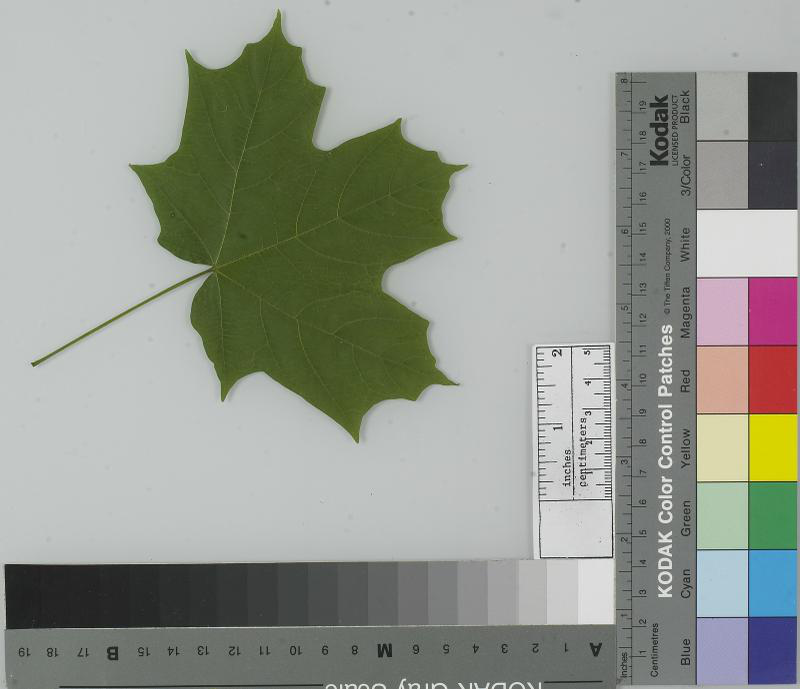

In [2]:
from PIL import Image
mapleImage = Image.open("/content/drive/Othercomputers/My Computer/RPI/21Fall/ProjectsMLAI/Projects-in-ML-and-AI/HW5/dataset/images/lab/acer_saccharum/pi0029-07-1.jpg")
display(mapleImage)

It looks like the segmentation often picked up the rulers and color strips along the sides, or sometimes nothing at all! 

Manually cleaning the dataset -- over 23,000+ examples -- would be tedious, to say the least. Let's automate the process using a CNN binary classifier.

---

To train the model, 350 examples each of errors and leaves from the data have been selected manually, across as many species as possible. Let's load that dataset and look at a sample:

Found 700 files belonging to 2 classes.
Dataset split into 28 batches of 25 examples each.


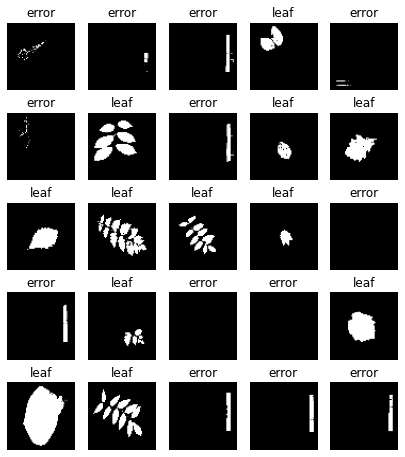

In [51]:
#load dataset
cleaningDir = "/content/drive/Othercomputers/My Computer/RPI/21Fall/ProjectsMLAI/Projects-in-ML-and-AI/HW5/dataset/cleaning"
scData = tf.keras.preprocessing.image_dataset_from_directory(cleaningDir, labels='inferred', color_mode='grayscale', image_size=imageSize, batch_size=batchSize, shuffle=True)
#note: I'll be using the prefix "sc" to indicate a variable is associated with cleaning the segmented data

#yield some information from dataset
scSize = scData.cardinality().numpy()
print("Dataset split into", scSize, "batches of", batchSize, "examples each.")

#display a sample of the dataset:
def labelSCData(numLabel): return "error" if numLabel == 0 else "leaf"
plt.figure(figsize=(7, 8))
for images, labels in scData.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")), cmap='gray', vmin=0, vmax=255)
        plt.title(labelSCData(int(labels[i])))
        plt.axis("off")

Next we split the data into training, validation, and testing sets:

In [52]:
scSplit = [0.7, 0.2, 0.1] #train/dev/test split ratios

#split the data
scTrainSize = int(scSplit[0] * scSize)
scDevSize = int(scSplit[1] * scSize)
scTrainSet = scData.take(scTrainSize)    
scDevSet = scData.skip(scTrainSize).take(scDevSize)
scTestSet = scData.skip(scTrainSize).skip(scDevSize)

print("At", batchSize, "examples per batch:")
print("> Train set example count:", scTrainSet.cardinality().numpy()*batchSize)
print("> Dev set example count:  ", scDevSet.cardinality().numpy()*batchSize)
print("> Test set example count: ", scTestSet.cardinality().numpy()*batchSize)

At 25 examples per batch:
> Train set example count: 475
> Dev set example count:   125
> Test set example count:  100


Now we construct the model, a simple CNN. 

A majority of errors are easy to identify: either the image is totally black, or is just black with a white bar on the right or bottom side. It would be feasible to identify these with a simpler model, or even a hand-crafted algorithm. 

But, to identify the errors that result in a noisy leaf shape, we need a more sophisticated technique like a CNN. The CNN evaluates data spacially, a necessary feature to identify a noisy region of an image vs. a flat one. So, that's what will be used for the classifier.

---

The architecture of this classifier is simple, to prioritize speed while retaining good accuracy. It's loosely inspired by LeNet-5. Hyperparameters were chosen through manual search.

In [53]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

#build the model
segmentationErrorClassifier = keras.Sequential ([
  Conv2D(4, 3, input_shape=(imageSize[0], imageSize[1], 1)), 
  MaxPooling2D(pool_size=2), #using max pooling to select for bright pixels on a dark background
  Conv2D(8, 3), 
  MaxPooling2D(pool_size=2), #using max pooling to select for bright pixels on a dark background
  Flatten(),
  Dense(32, activation="relu"),
  Dense(2, activation="softmax")
])

#compile the model
segmentationErrorClassifier.compile(
  'adam',
  loss='sparse_categorical_crossentropy', #this loss function is easily compatible with the dataset intake function used (tf.keras.preprocessing.image_dataset_from_directory())
  metrics=['accuracy'],
)

This function trains the model:

In [54]:
#trains the model, returning a list of validation accuracy measures at the end of each epoch 
def trainModel(model, epochs, trainSet, devSet, earlyStopping=1):
  accLog = []

  #train the model
  for e in range(epochs):
    model.fit(trainSet, epochs=1, validation_data=devSet, verbose=0)

    #record validation accuracy
    accLog += [ex for ex in model.history.history['val_accuracy']]

    #implementation of early stopping
    if(e != epochs-1 and accLog[len(accLog)-1] >= earlyStopping): 
      print("==> Validation accuracy exceeded (or met) %d%%, early stopping initiated at epoch %d." % (earlyStopping*100, e+1))
      break 

  return accLog

Now we train the model using that function, and plot its validation accuracy over training epochs:

==> Validation accuracy exceeded (or met) 98%, early stopping initiated at epoch 4.


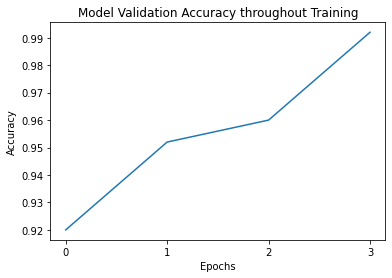

In [55]:
scEpochs = 10

#run 10 models
scTrainingLog = trainModel(segmentationErrorClassifier, scEpochs, scTrainSet, scDevSet, earlyStopping=0.98)

#graph accuracies
plt.xlabel("Epochs")
plt.xticks(range(0,scEpochs))
plt.ylabel("Accuracy")
plt.title("Model Validation Accuracy throughout Training")
plt.plot(scTrainingLog) 
plt.show()

Now we'll evaluate its accuracy on the test set:

In [56]:
segmentationErrorClassifier.evaluate(scTestSet)

4/4 [==============================] - 1s 15ms/step - loss: 0.1077 - accuracy: 0.9900


[0.10772190988063812, 0.9900000095367432]

That's a good result, so good that overfitting is a possibility. As long as the model generalizes well in practice, that's all that matters. 

With the model trained and tested for accuracy, let's apply it to the original dataset. All images that the model predicts are leaves will be stored in leafImagesList, with their corresponding labels in leafLabelsList. Any errors will be dropped.

This operation takes time, roughly an hour. To keep track of it, a progress bar has been implemented.

In [57]:
#progress bar code source: https://stackoverflow.com/questions/46939393/how-do-i-use-updatable-displays-on-colab
from IPython.display import HTML, display
import time
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))
  
out = display(progress(0, 100), display_id=True)


leafImagesList = []
leafLabelsList = []
predictedCount = 0
for image, label in lData.as_numpy_iterator():
  #print(labels)
  #plt.imshow(np.squeeze(image.astype("uint8")), cmap='gray', vmin=0, vmax=255)
  #print(image.shape)
  prediction = segmentationErrorClassifier.predict(image.reshape((1,64,64,1)))
  if prediction[0][1] > prediction[0][0]:
    leafImagesList.append(image)
    leafLabelsList.append(label)

  predictedCount = predictedCount + 1
  if(predictedCount % 100):
    #update progress bar
    out.update(progress(predictedCount, 23157))

Let's look at a sample of the cleaned data to see if the model was successful.

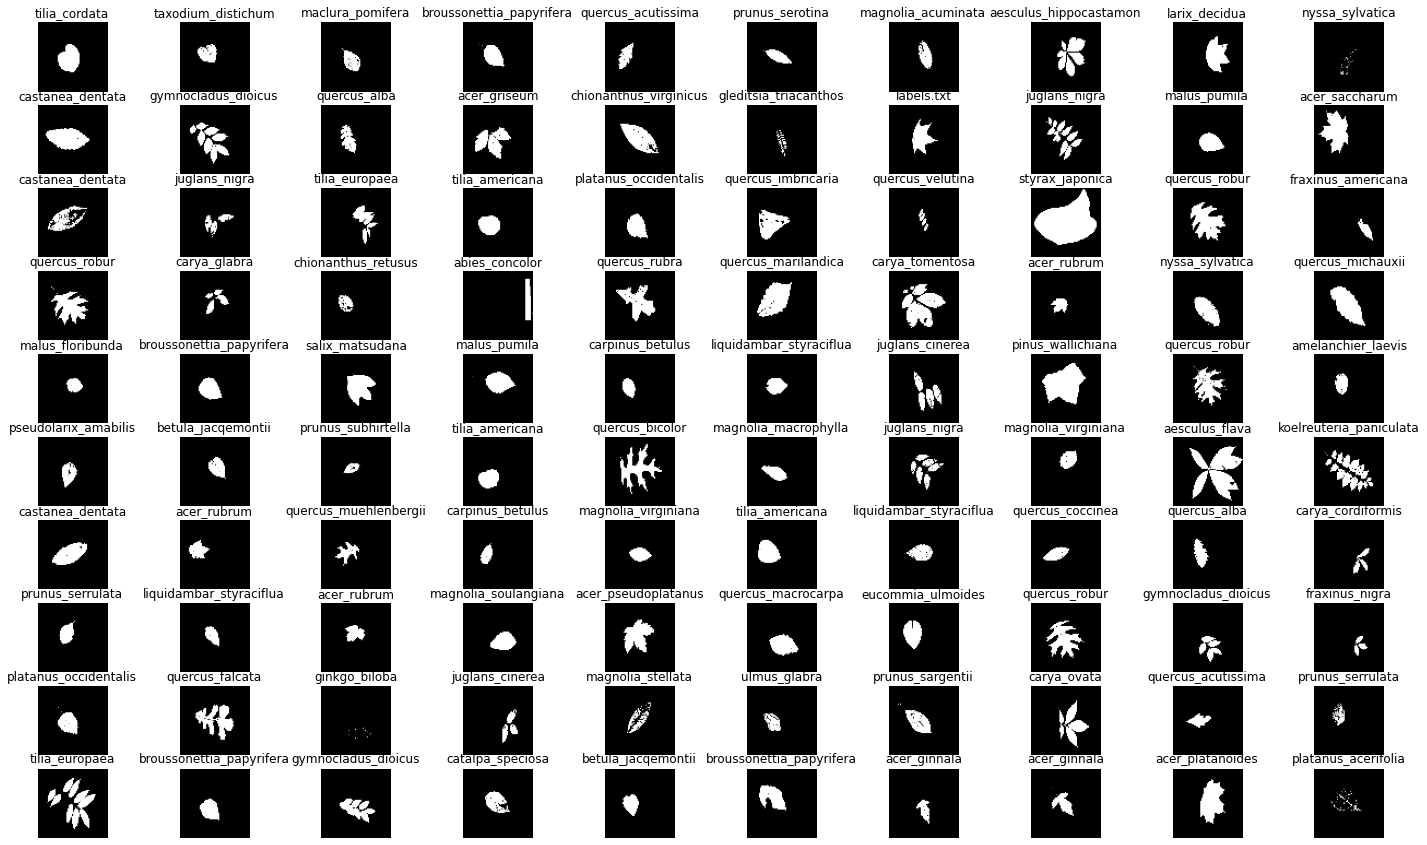

In [58]:
plt.figure(figsize=(25, 15))

for i in range(100):
  ax = plt.subplot(10, 10, i + 1)
  plt.imshow(np.squeeze(leafImagesList[i].astype("uint8")), cmap='gray', vmin=0, vmax=255)
  plt.title(speciesLabels[int(leafLabelsList[i])])
  plt.axis("off")

Though a few errors have passed through, the dataset is much better than before! Let's save the dataset to the disk. This cleaned dataset will be used for the assignment's main notebook.

In [64]:
#perform once to make the directories:
# import os
# path = "/content/drive/Othercomputers/My Computer/RPI/21Fall/ProjectsMLAI/Projects-in-ML-and-AI/HW5/dataset/segmented-justleaves/"
# for species in speciesLabels:
#   os.mkdir(path + species)

#save the images
for i in range(len(leafImagesList)):
  im = Image.fromarray(np.squeeze(leafImagesList[i].astype("uint8")))
  im.save("/content/drive/Othercomputers/My Computer/RPI/21Fall/ProjectsMLAI/Projects-in-ML-and-AI/HW5/dataset/segmented-justleaves/" + speciesLabels[leafLabelsList[i]] + "/" + str(i) + ".png")